# Pattern Recognition - Tarea 2 - Automatic Segmentation

## Introduction

In [2]:
# basic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# image
import PIL
from skimage import io
from skimage.color import rgb2gray
import scipy
from scipy.signal import convolve2d

# ML / classification
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

We are firstly going to read all images.

In [3]:
# estagblishing the paths
img_path = "/home/osboxes/Documents/python/recpatr/auto-segmentation/"
# img_path = "/u/a/2019/apoupeau/Documentos/recpatr/auto-segmentation"
img_raw_path = os.path.join(img_path, "datos_tarea2/raw.tif")
img_seg_path = os.path.join(img_path, "datos_tarea2/segmentacion_referencia.tif")

# getting raw and ground truth data
raw_data = io.imread(img_raw_path)
seg_data = np.array((1/255) * io.imread(img_seg_path), dtype=int) # class 0 : 255 => to 0 : 1

# get info 55 images of shape 512x512
print(raw_data.shape)
print(seg_data.shape)

print("min-max values raw :", np.min(raw_data), np.max(raw_data))
print("min-max values seg :", np.min(seg_data), np.max(seg_data))

(55, 512, 512)
(55, 512, 512)
min-max values raw : 1 255
min-max values seg : 0 1


Create some tools functions like display an image.

## Convolution 

We want to extract caracteristics from each images. In order to do that we will first create three kernels (filters) and a function that make the convolution. 

http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html

In [4]:
# KERNELS
mean_kernel = 1/9 * np.ones(shape=(3,3))

sobelx_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])

sobely_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]])

laplacian_kernel = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]])

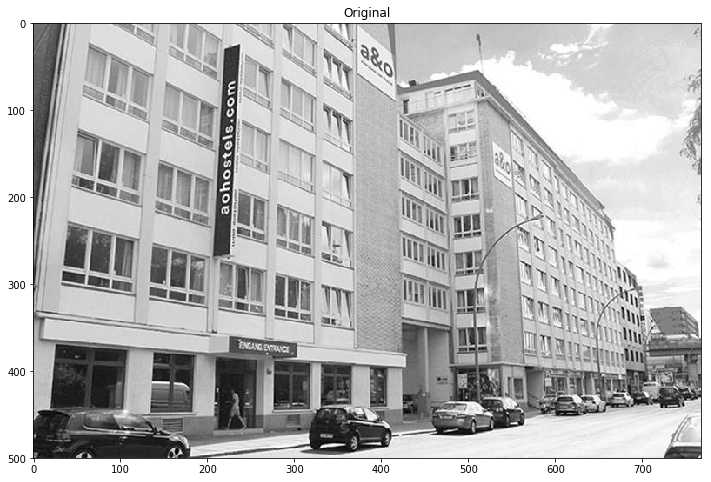

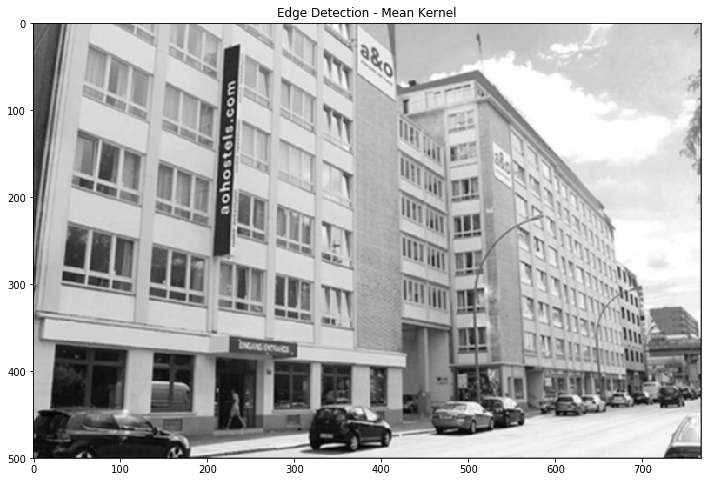

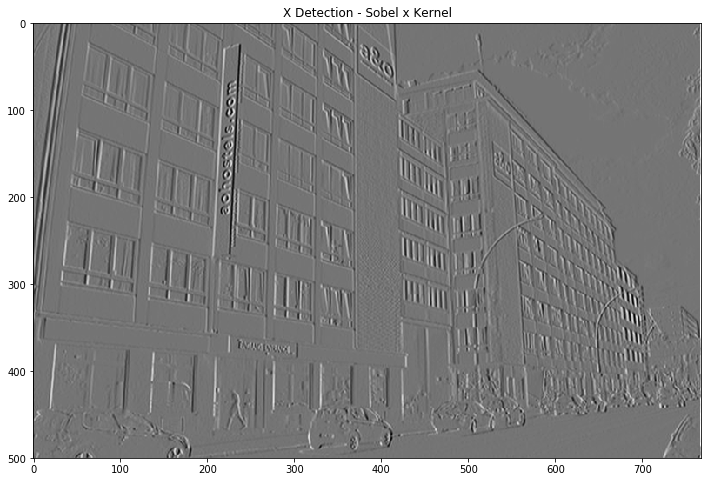

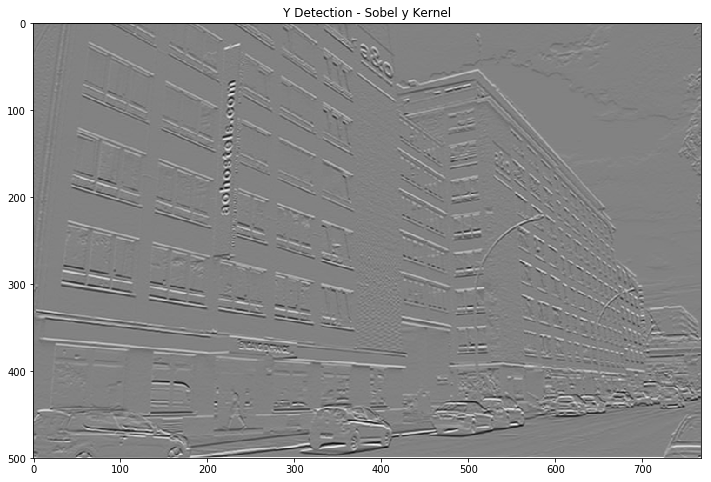

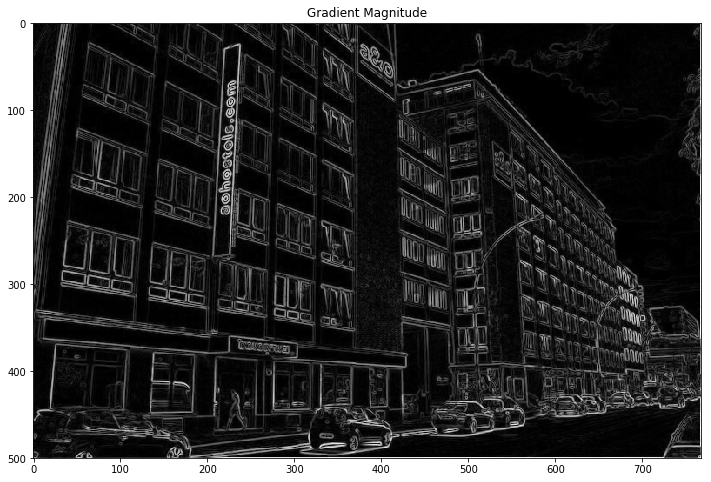

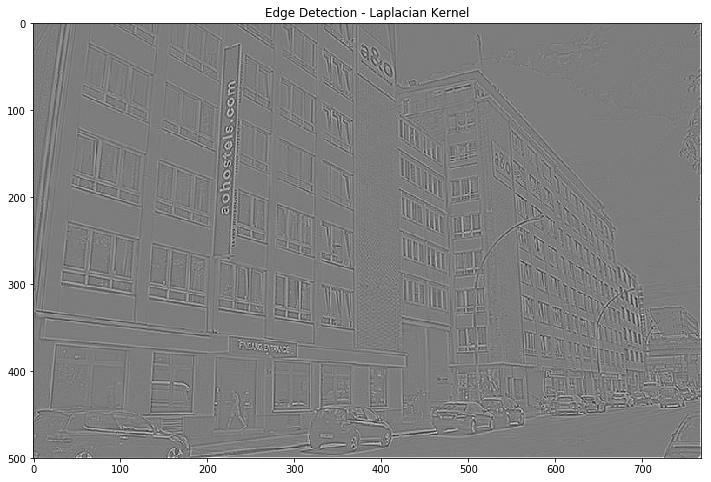

In [5]:
def testConvolution():
    test_img = io.imread(os.path.join(img_path, "img/building.jpg"))
    # test_img = io.imread(os.path.join(img_path, "img/chair.jpg"))
    # test_img = raw_data[0]
    test_img = rgb2gray(test_img)

    # original img
    plt.figure(figsize=(14,8))
    plt.title("Original")
    plt.imshow(test_img, cmap="gray")
    plt.show()

    # mean kernel
    trans_img = convolve2d(test_img, mean_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("Edge Detection - Mean Kernel")
    plt.imshow(trans_img, cmap="gray")
    plt.show()

    # sobelx kernel
    transx_img = convolve2d(test_img, sobelx_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("X Detection - Sobel x Kernel")
    plt.imshow(transx_img, cmap="gray")
    plt.show()

    # sobely kernel
    transy_img = convolve2d(test_img, sobely_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("Y Detection - Sobel y Kernel")
    plt.imshow(transy_img, cmap="gray")
    plt.show()

    # gradient magnitud
    grad_mag = np.sqrt(transx_img**2 + transy_img**2)
    plt.figure(figsize=(14,8))
    plt.title("Gradient Magnitude")
    plt.imshow(grad_mag, cmap="gray")
    plt.show()

    # laplacian kernel
    trans_img = convolve2d(test_img, laplacian_kernel, "same")
    plt.figure(figsize=(14,8))
    plt.title("Edge Detection - Laplacian Kernel")
    plt.imshow(trans_img, cmap="gray")
    plt.show()
testConvolution()

## Extract features

We have to extract the three features per pixel for each image. The function thus takes as an input an image of shape (512x512) and returns three "modified" images which shape is equal to (512x512).

In [6]:
def extractFeatures(img, flatten=False):
    """
        Compute three features : mean, magnitud and edge detection.
        
        Arguments:
            img (array) : shape (512,512)
            flatten (bool) : if true return a shape (512*512, 3)
        
        Return:
            features (array) : shape (3,512,512) or (512*512, 3) if flatten=True
    """
    # mean kernel
    blurred_img = convolve2d(img, mean_kernel, "same")
    
    # gradient magnitud
    transx_img = convolve2d(img, sobelx_kernel, "same")
    transy_img = convolve2d(img, sobely_kernel, "same")
    grad_mag = np.sqrt(transx_img**2 + transy_img**2)

    # laplacian kernel
    lap_img = convolve2d(img, laplacian_kernel, "same")
    
    # concatenate
    features = np.array([blurred_img, grad_mag, lap_img])
    if flatten:
        flatten_features_img = np.zeros(shape=(3, len(lap_img)**2))
        for i, feature in enumerate(features):
            flatten_features_img[i] = feature.flatten()
        features = flatten_features_img.T
    
    return features

In [7]:
# test
print(extractFeatures(raw_data[0]).shape)
print(extractFeatures(raw_data[0], flatten=True).shape)

(3, 512, 512)
(262144, 3)


In [8]:
def linkImgFeaturesAndClass(img, class_pixels_img):
    """
        Arguments:
            img (array) : raw image (512,512)
            class_pixels_img (array) : values 0 or 1 in it, class for each pixel of the img
        
        Return:
            features_and_class (array) : shape (512*512, 4)
    """
    # extract features
    features_img = extractFeatures(img=img)
    
    # get dataset for the current img
    shp = features_img.shape
    flatten_features_img = np.zeros(shape=(4, shp[-1]**2))
    for i, feature in enumerate(features_img):
        flatten_features_img[i] = feature.flatten()
    
    # concatenate class_pixels_img and features
    flatten_features_img[-1] = class_pixels_img.flatten()
    features_and_class = flatten_features_img.T
    
    return features_and_class

In [9]:
# test ok
linkImgFeaturesAndClass(raw_data[0], seg_data[0]).shape

(262144, 4)

## Construct dataset

In [10]:
# just to show the why of the "ONLY 1 PREDICTION PROBLEM"
print(seg_data[0,106])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [11]:
def computeclfDataset(X, y, nb_max_img=55):
    """
        Arguments:
            X (array) : all raw images
            y (array) : label for all pixel
            nb_max_img (int) : value in [1, 55], default all images
        
        Return:
            dataset (array) : (nb_max_img*512*512, n_features+1 = 4)
    """
    dataset = np.array([0, 0, 0, 0])
    for img, class_pixels_img in zip(X[:nb_max_img], y[:nb_max_img]):
        dataset = np.vstack((dataset, linkImgFeaturesAndClass(img, class_pixels_img)))
    # get rid of the first row
    dataset = dataset[1:, :]
    return dataset

In [12]:
clf_dataset = computeclfDataset(X=raw_data, y=seg_data, nb_max_img=5)

In [13]:
# test
print(clf_dataset.shape)

(1310720, 4)


In [14]:
def equilibrate(dataset, margin, disp=False):
    """
        Help to solve the "ONLY 1 PREDICTION PROBLEM".
    
        Arguments:
            dataset (array) : shape (n_samples, n_features)
            margin (int) : if 1 => nb_ones = nb_zeros, if 2 => nb_ones = 2*nb_zeros
            
        Return:
            dataset (array) : shape (n < n_samples, n_features)
    """
    nb_zeros = len(dataset[dataset[:, -1] == 0])
    if disp:
        print("Number of 0 class samples =", nb_zeros)
        print("Number of 1 class samples =", len(dataset) - nb_zeros)
        print("Equilibrating...")
    
    # equilibrate dataset in a quick way
    np.random.shuffle(dataset)
    subset_ones = dataset[dataset[:, -1] == 1][:int(nb_zeros*margin), :]
    subset_zeros = dataset[dataset[:, -1] == 0]
    dataset = np.vstack((subset_ones, subset_zeros))
    np.random.shuffle(dataset)
    
    if disp:
        nb_zeros = len(dataset[dataset[:, -1] == 0])
        print("Number of 0 class samples =", nb_zeros)
        print("Number of 1 class samples =", len(dataset) - nb_zeros)
    
    return dataset

In [15]:
eq_clf_dataset = equilibrate(clf_dataset, disp=True, margin=1.1)

Number of 0 class samples = 217063
Number of 1 class samples = 1093657
Equilibrating...
Number of 0 class samples = 217063
Number of 1 class samples = 238769


## Segmentation

Now we are going to classify using the dataset tools we have.

In [16]:
def getMetricsAndEval(y_true, y_pred, y_pred_proba, 
                      disp=True, disp_conf_mat=True, disp_roc=True, 
                      disp_metrics=True, model="Not Mentioned"):
    print("\nModel :", model)
    conf_mat = confusion_matrix(y_pred=y_pred, y_true=y_true)
    tn, fp, fn, tp = conf_mat.ravel()
    acc = np.sum(np.diag(conf_mat))/np.sum(conf_mat)
    auc = roc_auc_score(y_score=y_pred_proba ,y_true=y_true)
    NPV = tn/(fn+tn)
    TNR = tn/(fp+tn) # specificity
    seg_score = 2*NPV*TNR/(NPV+TNR)
    if disp:
        if disp_metrics:
            print("Acc :", acc)
            print("AUC :", auc)
            print("NPV :", NPV)
            print("TNR :", TNR)
            print("Seg-score", seg_score)
        
        if disp_conf_mat:
            plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=[0, 1], title="Confusion Matrix - "+model)
            plt.show()
        
        if disp_roc:
            fpr, tpr, _ = roc_curve(y_score=y_pred_proba ,y_true=y_true)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr, tpr, label='ROC '+str(model))
            plt.legend()
            plt.title("ROC curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
    else:
        return acc, auc, NPV, TNR, seg_score

In [17]:
X, y = eq_clf_dataset[:, :-1], eq_clf_dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, n_jobs=64)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=64,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


Model : Not Mentioned
Acc : 0.6493747714808044
AUC : 0.6617917485482996
NPV : 0.6845715764949521
TNR : 0.48776513987088843
Seg-score 0.5696488834637754
Confusion matrix, without normalization
[[31734 33326]
 [14622 57068]]


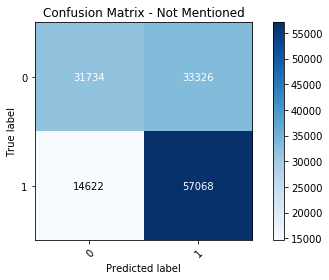

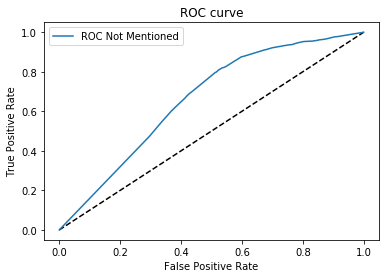

In [19]:
y_pred_test = clf.predict(X_test)
y_proba_test = clf.predict_proba(X_test)[:, 1]

getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_proba_test)

We need to analyze how good it can predict the class. The idea is to visualize this with a image.

In [20]:
def visuImgClf(img, trained_clf):
    """
        Arguments:
            img (array) : image
            trained_clf (sklearn classifier) : classifier
            
        Return:
            predictions (array) : classified image
    """
    features_img = extractFeatures(img=img, flatten=True)
    
    predictions = trained_clf.predict(features_img)
    
    return predictions

In [21]:
def displayPredAndTrue(img, trained_clf, class_pixels_img):
    """
        Arguments:
            img (array) : image
            trained_clf (sklearn classifier) : classifier
            class_pixels_img (array) : ground truth classification
            
        Dsiplay:
            3 images :
                -image
                -image prediction
                -ground truth
    """
    # get predictions class for all pixel in the image
    predictions = visuImgClf(img=img, trained_clf=trained_clf)
    nb_zeros = len(predictions[predictions == 0])
    print("Number of predicted zeros =", nb_zeros)
    print("Number of predicted ones =", len(predictions) - nb_zeros)

    # reshape into an image and 0 : 1 => 0 : 255
    n = len(class_pixels_img)
    predictions = 255 * np.reshape(predictions, (n, n))
    class_pixels_img *= 255

    # disp images
    plt.imshow(predictions, cmap="gray")
    plt.title("Prediction")
    plt.show()

    plt.imshow(class_pixels_img, cmap="gray")
    plt.title("Ground Truth")
    plt.show()

Image negative index = -7
Number of predicted zeros = 74873
Number of predicted ones = 187271


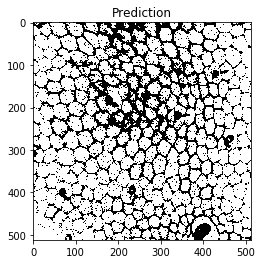

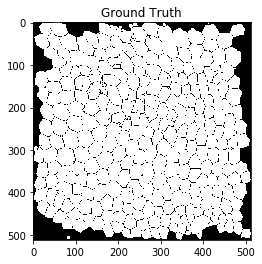

In [22]:
random_visu_idx = -np.random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print("Image negative index =", random_visu_idx)
displayPredAndTrue(img=raw_data[random_visu_idx], 
                   trained_clf=clf, 
                   class_pixels_img=seg_data[random_visu_idx])

## Margin Hyperparameter study

This part is dedicated to te study of the best margin hyperparameter. It was important to evaluate how good a model is to do segmentation. This is more than just related to the accuracy of the model but more about other metrics such as True Negative Rate (TNR). This metric evaluates the following : for all the negative labeled elements, what is percentage of true negative ? This informs about quantity of well classified elements, not the quality. NPV informs on the quality : for all the negative elements predicted, what is the pourcentage of real negative labeled elements ?

In [38]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def TNR_score(y_true, y_pred): return tn(y_true, y_pred)/(tn(y_true, y_pred)+fp(y_true, y_pred))
def NPV_score(y_true, y_pred): return tn(y_true, y_pred)/(tn(y_true, y_pred)+fn(y_true, y_pred))
def seg_score(y_true, y_pred): return 2*NPV_score(y_true, y_pred)*TNR_score(y_true, y_pred)/(NPV_score(y_true, y_pred)+TNR_score(y_true, y_pred))

Equilibrating clf_dataset with margin 0.1...
Evaluating...
Number of predicted zeros = 262144
Number of predicted ones = 0


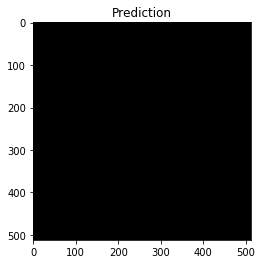

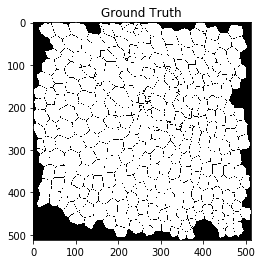

Equilibrating clf_dataset with margin 0.75...
Evaluating...
Number of predicted zeros = 129317
Number of predicted ones = 132827


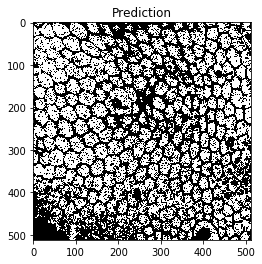

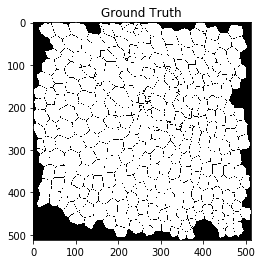

Equilibrating clf_dataset with margin 1...
Evaluating...
Number of predicted zeros = 98112
Number of predicted ones = 164032


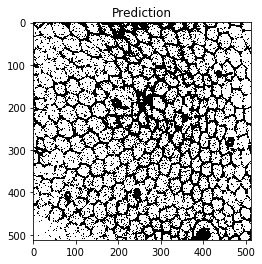

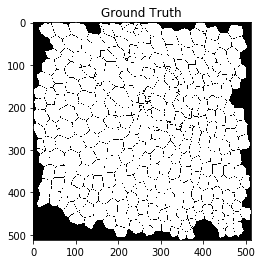

Equilibrating clf_dataset with margin 1.5...
Evaluating...
Number of predicted zeros = 46350
Number of predicted ones = 215794


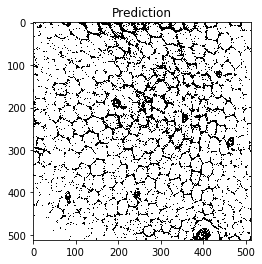

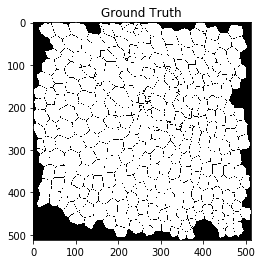

Equilibrating clf_dataset with margin 2...
Evaluating...
Number of predicted zeros = 15980
Number of predicted ones = 246164


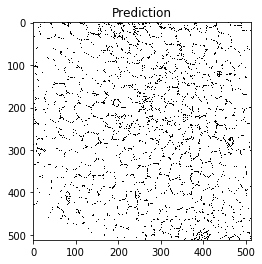

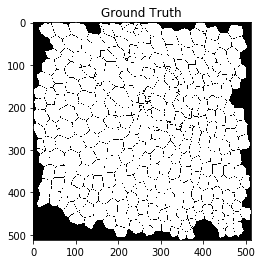

Equilibrating clf_dataset with margin 5...
Evaluating...


/home/osboxes/Documents/deeplrn-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/osboxes/Documents/deeplrn-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/osboxes/Documents/deeplrn-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/osboxes/Documents/deeplrn-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()


Number of predicted zeros = 0
Number of predicted ones = 262144


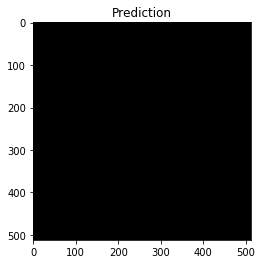

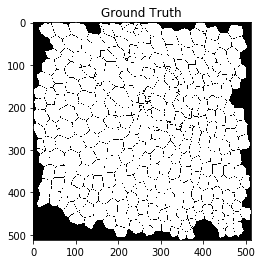

In [163]:
diff_margins = [0.1, 0.75, 1, 1.5, 2, 5]
stock_margin_results = np.zeros(shape=(len(diff_margins), len(scoring)+1))
for i, margin in enumerate(diff_margins):
    print("Equilibrating clf_dataset with margin " +str(margin)+ "...")
    eq_clf_dataset = equilibrate(clf_dataset, margin=margin)
    X, y = eq_clf_dataset[:, :-1], eq_clf_dataset[:, -1]
    print("Evaluating...")
    tmp_cv_clf = RandomForestClassifier(n_estimators=10, max_depth=2, n_jobs=32)
    scoring = {'acc': make_scorer(accuracy_score), 'tnr': make_scorer(TNR_score), 
               'npv': make_scorer(NPV_score), 'seg_s': make_scorer(seg_score),
               'auc': make_scorer(roc_auc_score)}
    cv_results = cross_validate(tmp_cv_clf, X, y, scoring=scoring, cv=2, n_jobs=-1)
    displayPredAndTrue(img=raw_data[-1], 
                   trained_clf=tmp_cv_clf.fit(X,y), 
                   class_pixels_img=seg_data[-1])
    acc = np.mean(cv_results["test_acc"])
    tnr = np.mean(cv_results["test_tnr"])
    npv = np.mean(cv_results["test_npv"])
    seg_s = np.mean(cv_results["test_seg_s"])
    auc = np.mean(cv_results["test_auc"])
    # stock values
    stock_margin_results[i] = np.array([margin, acc, auc, tnr, npv, seg_s])

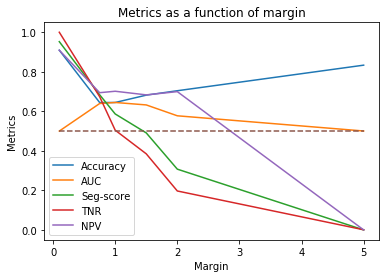

[array([0.1       , 0.90909205, 0.5       , 1.        , 0.90909205,
       0.95238158]), array([0.75      , 0.64434518, 0.63944685, 0.67373509, 0.69421677,
       0.68348335]), array([1.        , 0.64469071, 0.64469071, 0.50452641, 0.70149088,
       0.58664464]), array([1.5       , 0.68178795, 0.63231181, 0.38492988, 0.68312621,
       0.49076155]), array([2.        , 0.70412123, 0.57733123, 0.19696125, 0.69955466,
       0.3073755 ]), array([5.00000000e+00, 8.33453882e-01, 5.00361644e-01, 7.23288984e-04,
       0.00000000e+00, 0.00000000e+00])]


In [6]:
stock_margin_results = np.array([np.array([0.1       , 0.90909205, 0.5       , 1.        , 0.90909205,
       0.95238158]), np.array([0.75      , 0.64434518, 0.63944685, 0.67373509, 0.69421677,
       0.68348335]), np.array([1.        , 0.64469071, 0.64469071, 0.50452641, 0.70149088,
       0.58664464]), np.array([1.5       , 0.68178795, 0.63231181, 0.38492988, 0.68312621,
       0.49076155]), np.array([2.        , 0.70412123, 0.57733123, 0.19696125, 0.69955466,
       0.3073755 ]), np.array([5.00000000e+00, 8.33453882e-01, 5.00361644e-01, 7.23288984e-04,
                  0,            0])])
plt.plot(stock_margin_results[:, 0], stock_margin_results[:, 1], label="Accuracy")
plt.plot(stock_margin_results[:, 0], stock_margin_results[:, 2], label="AUC")
plt.plot(stock_margin_results[:, 0], stock_margin_results[:, 5], label="Seg-score")
plt.plot(stock_margin_results[:, 0], stock_margin_results[:, 3], label="TNR")
plt.plot(stock_margin_results[:, 0], stock_margin_results[:, 4], label="NPV")
plt.plot([0.1, 5], [0.5, 0.5], "--")
plt.legend()
plt.title("Metrics as a function of margin")
plt.xlabel("Margin")
plt.ylabel("Metrics")
plt.show()

## Best model selection - Cross-Validation & Grid Search

We are going to use cross-validation in order to evaluate different models and for each model the best hyperparameters possible.

In [23]:
eq_clf_dataset = equilibrate(clf_dataset, margin=1.25)

In [39]:
def computeGDCV(estimator, params_grid, eq_clf_dataset=eq_clf_dataset, cv=3):
    """
        
        Arguments:
            eq_clf_dataset (array) : equilibrated with margin dataset.
                shape = (n_samples, n_features+1) for label
    """
    X, y = eq_clf_dataset[:, :-1], eq_clf_dataset[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    scoring = {'acc': make_scorer(accuracy_score), 'tnr': make_scorer(TNR_score), 
               'npv': make_scorer(NPV_score), 'seg_s': make_scorer(seg_score),
               'auc': make_scorer(roc_auc_score)}
    opt_clf = GridSearchCV(estimator=estimator,
                           param_grid=params_grid,
                           scoring=make_scorer(seg_score),
                           cv=cv,
                           n_jobs=-1,
                           verbose=5)
    opt_clf.fit(X_train, y_train)
    return opt_clf

### Random Forest Hyperparameters Tuning

In [43]:
evaluate1 =[[RandomForestClassifier(n_jobs=-1), 
            {'n_estimators':[70], 
             'max_depth': [10]}]]
gdcv_clf_rf = computeGDCV(estimator=evaluate1[0][0], params_grid=evaluate1[0][1])
print(gdcv_clf_rf.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   34.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### MLP Hyperparameters Tuning

In [47]:
evaluate2 =[[MLPClassifier(), 
            {'hidden_layer_sizes':[(4, 4, 4)], 
             'activation': ["tanh"]}]]
gdcv_clf_mlp = computeGDCV(estimator=evaluate2[0][0], params_grid=evaluate2[0][1])
print(gdcv_clf_mlp.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 4, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


### KNeighbors Hyperparameters Tuning

In [40]:
evaluate3 =[[KNeighborsClassifier(n_jobs=-1), 
            {'n_neighbors': [12], 'p': [1]}]]
gdcv_clf_kn = computeGDCV(estimator=evaluate3[0][0], params_grid=evaluate3[0][1])
print(gdcv_clf_kn.best_estimator_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.3s finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=12, p=1,
           weights='uniform')


### Evaluation of each model


Model : RandomForest
Acc : 0.7008558675384594
AUC : 0.7439850715519633
NPV : 0.7185124974598659
TNR : 0.5411717889065752
Seg-score 0.6173589649573097

Model : MLP
Acc : 0.6923859184537053
AUC : 0.73116126623454
NPV : 0.7081236520488857
TNR : 0.5276570344067589
Seg-score 0.6047131668727691

Model : KNeighbors
Acc : 0.705053304030904
AUC : 0.7633250242641404
NPV : 0.6816561827647938
TNR : 0.6352393779845721
Seg-score 0.6576297505209036


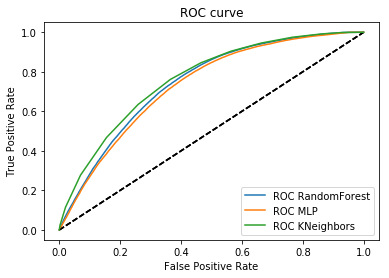

In [251]:
X, y = eq_clf_dataset[:, :-1], eq_clf_dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# random Forest
y_pred_test = gdcv_clf_rf.predict(X_test)
y_pred_proba_test = gdcv_clf_rf.predict_proba(X_test)[:, 1]
getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_pred_proba_test, 
                  disp_conf_mat=False, model="RandomForest")

# MLP
y_pred_test = gdcv_clf_mlp.predict(X_test)
y_pred_proba_test = gdcv_clf_mlp.predict_proba(X_test)[:, 1]
getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_pred_proba_test, 
                  disp_conf_mat=False, model="MLP")

# Kneighbors
y_pred_test = gdcv_clf_kn.predict(X_test)
y_pred_proba_test = gdcv_clf_kn.predict_proba(X_test)[:, 1]
getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_pred_proba_test, 
                  disp_conf_mat=False, model="KNeighbors")


Model : RandomForest
Confusion matrix, without normalization
[[35358 29978]
 [13852 67330]]


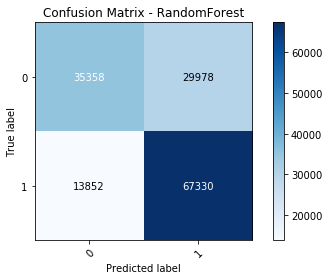


Model : MLP
Confusion matrix, without normalization
[[34475 30861]
 [14210 66972]]


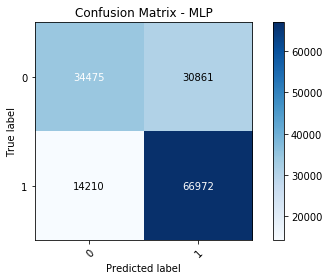


Model : KNeighbors
Confusion matrix, without normalization
[[41504 23832]
 [19383 61799]]


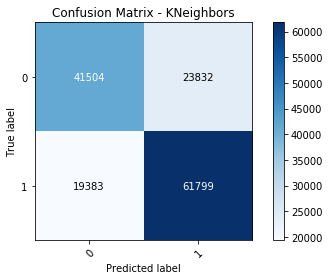

In [258]:
# random Forest
y_pred_test = gdcv_clf_rf.predict(X_test)
y_pred_proba_test = gdcv_clf_rf.predict_proba(X_test)[:, 1]
getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_pred_proba_test, 
                  disp_metrics=False, disp_roc=False, model="RandomForest")

# MLP
y_pred_test = gdcv_clf_mlp.predict(X_test)
y_pred_proba_test = gdcv_clf_mlp.predict_proba(X_test)[:, 1]
getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_pred_proba_test, 
                  disp_metrics=False, disp_roc=False, model="MLP")

# KN
y_pred_test = gdcv_clf_kn.predict(X_test)
y_pred_proba_test = gdcv_clf_kn.predict_proba(X_test)[:, 1]
getMetricsAndEval(y_true=y_test, y_pred=y_pred_test, y_pred_proba=y_pred_proba_test, 
                  disp_metrics=False, disp_roc=False, model="KNeighbors")

Number of predicted zeros = 96925
Number of predicted ones = 165219


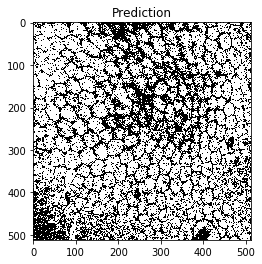

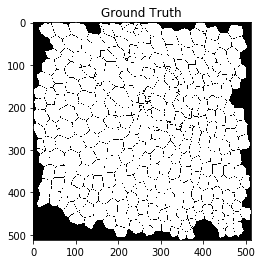

In [49]:
# Visualize the segmentation result for the best model
displayPredAndTrue(img=raw_data[-1], 
                   trained_clf=gdcv_clf_kn, 
                   class_pixels_img=seg_data[-1])